<a href="https://colab.research.google.com/github/kithmiGunawardna/Hate_Speech_detection/blob/master/Final_selected__model(BILSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install keras-preprocessing
!pip install lime


In [ ]:
#import relevant libraraies
import pandas as pd
import numpy as np
from google.colab import drive

#imprtant libraris for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for deep learning

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import string
from sklearn.utils import resample
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split

import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

#word embading using pretrain model
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer


#LSTM model
from tensorflow.keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense,SpatialDropout1D


from keras.initializers import Constant
from keras.callbacks import EarlyStopping

#validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



#hide warning
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorboard.plugins.hparams import api as hp
from tensorboard.plugins.hparams import api as hp


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
#import dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Campus_Research/New_data.csv',encoding='latin1')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
27474,27988,3,0,3,0,1,"""The term whore was used inappropriately, caus..."
27475,27989,3,0,3,0,1,"""She felt marginalized and attacked by the con..."
27476,27990,3,0,3,0,1,"""The use of whore as an insult was both damagi..."
27477,27991,3,0,3,0,1,"""He was warned about the harmful effects of us..."


**Cleaning the dataset**

In [ ]:
#preprossesing part
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_mentions = tf.strings.regex_replace(stripped_html, r"@\w+", " ")
  stripped_hashtags = tf.strings.regex_replace(stripped_mentions, r"#\w+", " ")
  # Expand emoticons with appropriate library
  # stripped_emoticons = ...
  stripped_urls = tf.strings.regex_replace(stripped_hashtags, r"http(?s://)?\S+", " ")
  # Remove punctuation (existing logic)
  return tf.strings.regex_replace(stripped_urls, '[%s]' % re.escape(string.punctuation), '').numpy().decode('utf-8')

In [ ]:
# Apply clean_text function
df.loc[:, 'tweet'] = df['tweet'].apply(custom_standardization)

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about c...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she ...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true...
...,...,...,...,...,...,...,...
27474,27988,3,0,3,0,1,the term whore was used inappropriately causin...
27475,27989,3,0,3,0,1,she felt marginalized and attacked by the cons...
27476,27990,3,0,3,0,1,the use of whore as an insult was both damagin...
27477,27991,3,0,3,0,1,he was warned about the harmful effects of usi...


In [ ]:
df['tweet']

,tweet
0,rt as a woman you shouldnt complain about c...
1,rt boy dats coldtyga dwn bad for cuffin dat...
2,rt dawg rt you ever fuck a bitch and she ...
3,rt she look like a tranny
4,rt the shit you hear about me might be true...
...,...
27474,the term whore was used inappropriately causin...
27475,she felt marginalized and attacked by the cons...
27476,the use of whore as an insult was both damagin...
27477,he was warned about the harmful effects of usi...


In [ ]:
df1 =df[['class', 'tweet']]
df1



,class,tweet
0,2,rt as a woman you shouldnt complain about c...
1,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,1,rt dawg rt you ever fuck a bitch and she ...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true...
...,...,...
27474,1,the term whore was used inappropriately causin...
27475,1,she felt marginalized and attacked by the cons...
27476,1,the use of whore as an insult was both damagin...
27477,1,he was warned about the harmful effects of usi...


**Unbalanced data set**

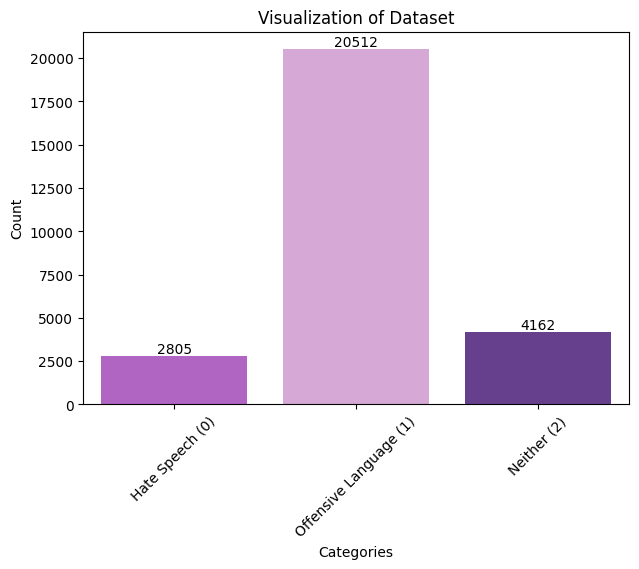

In [ ]:
# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['mediumorchid', 'plum', 'rebeccapurple']  # Purple shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')





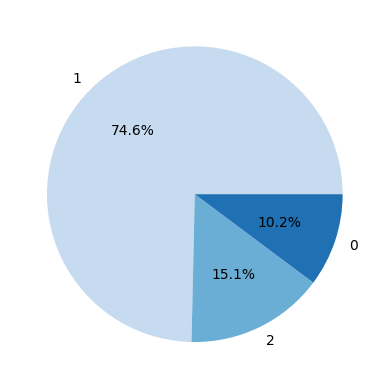

In [ ]:
blue_palette = sns.color_palette("Blues", n_colors=3)  # Customize 'n_colors' based on the number of slices

# Create a pie chart with the blue color palette
plt.pie(
    df['class'].value_counts().values,  # Values for the pie chart
    labels=df['class'].value_counts().index,  # Labels for each slice
    autopct='%1.1f%%',  # Display the percentage with one decimal place
    colors=blue_palette  # Set the color palette to shades of blue
)

# Display the pie chart
plt.show()

In [ ]:
y = df['class']
x = df.tweet

 **Balanced dataset using oversampling**

In [ ]:
#create two different dataframe of majority and minority class
df_class_1 = df1[(df1['class']==1)]
df_class_2 = df1[(df1['class']==2)]
df_class_0 = df1[(df1['class']==0)]
# undersample class_1 class
df_class_2_oversampled = resample(df_class_2,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# undersample class_1 class
df_class_0_oversampled = resample(df_class_0,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
oversampled_df  = pd.concat([df_class_2_oversampled, df_class_0_oversampled,df_class_1])

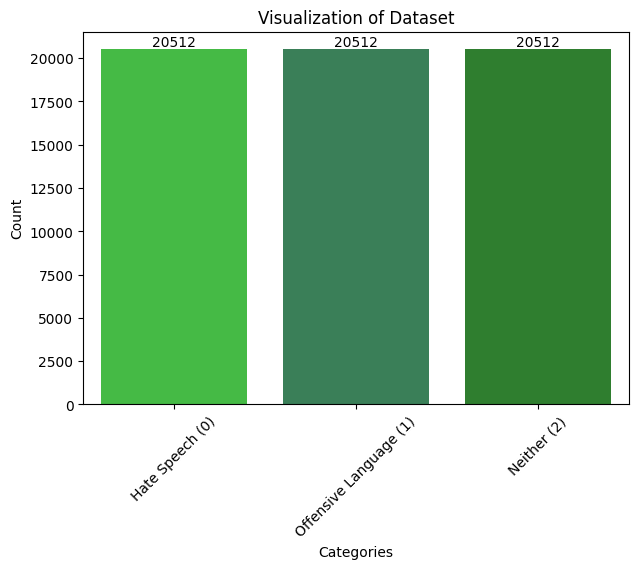

In [ ]:

# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = oversampled_df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['limegreen', 'seagreen', 'forestgreen']  # green shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')

In [ ]:
oversampled_df

,class,tweet
5077,2,dont you have a trash can
22175,2,three little birds
18224,2,rt rt ive met few people in politics that ...
2870,2,his defense is trash and hes been rocked by ...
20202,2,rt full set except the last song from sout...
...,...,...
27474,1,the term whore was used inappropriately causin...
27475,1,she felt marginalized and attacked by the cons...
27476,1,the use of whore as an insult was both damagin...
27477,1,he was warned about the harmful effects of usi...


In [ ]:
oversampled_df.to_csv('/content/drive/My Drive/df.csv', index=False)

In [ ]:
unique_values = oversampled_df['tweet'].nunique()
print(unique_values)


26685


**Training word2Vec model**

In [ ]:
# Define the vocabulary size and the number of words in a sequence.
vocab_size = 50000
sequence_length = 35

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

In [ ]:


# Assuming oversampled_df is a Pandas DataFrame with a 'tweet' column
tweets = oversampled_df['tweet'].values

# Step 1: Convert the 'tweet' column to a TensorFlow Dataset
text_ds = tf.data.Dataset.from_tensor_slices(tweets)

# Step 2: Filter out any empty tweets
text_ds = text_ds.filter(lambda x: tf.cast(tf.strings.length(x), bool))

# Step 3: Batch the dataset and adapt the vectorize_layer
vectorize_layer.adapt(text_ds.batch(1024))


In [ ]:
text_ds

<_FilterDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
# Save the created vocabulary for reference.
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'a', 'the', 'to', 'i', 'rt', 'you', 'and', 'bitch', 'in', 'that', 'of', 'is', 'my', 'like', 'for', 'me', 'be', 'on']


In [ ]:

# Import AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

# Vectorize the data in text_ds
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()


In [ ]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

61536


In [ ]:
# Generates skip-gram pairs with negative sampling for a list of sequences
# (int-encoded sentences) based on window size, number of negative samples
# and vocabulary size.
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm.tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.expand_dims(
          tf.constant([context_word], dtype="int64"), 1)
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [ ]:
targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=2,
    num_ns=4,
    vocab_size=vocab_size,
    seed=42)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|██████████| 61536/61536 [05:19<00:00, 192.46it/s]




targets.shape: (471121,)
contexts.shape: (471121, 5)
labels.shape: (471121, 5)


In [ ]:
BATCH_SIZE = 1024
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)


<_PrefetchDataset element_spec=((TensorSpec(shape=(1024,), dtype=tf.int64, name=None), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(1024, 5), dtype=tf.int64, name=None))>


In [ ]:
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)
    # context_emb: (batch, context, embed)
    dots = tf.einsum('be,bce->bc', word_emb, context_emb)
    # dots: (batch, context)
    return dots

In [ ]:
def custom_loss(x_logit, y_true):
      return tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=y_true)

In [ ]:
embedding_dim = 128
word2vec = Word2Vec(vocab_size, embedding_dim)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [ ]:
word2vec.fit(dataset, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4464 - loss: 1.5686
Epoch 2/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6036 - loss: 1.2557
Epoch 3/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7485 - loss: 0.9009
Epoch 4/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8210 - loss: 0.6551
Epoch 5/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8597 - loss: 0.5027
Epoch 6/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8863 - loss: 0.4048
Epoch 7/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9059 - loss: 0.3377
Epoch 8/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9201 - loss: 0.2889
Epoch 9/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9309 - loss: 0.2519
Epoch 10/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9393 - loss: 0.2230
Epoch 11/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9460 - loss: 0.1998
Epoch 12/20
460/460 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step

**Data Spliting**

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(oversampled_df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21018 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(oversampled_df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (61536, 250)


In [ ]:
Y = pd.get_dummies(oversampled_df['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (61536, 3)


In [ ]:
word_embeddings = word2vec.target_embedding.get_weights()[0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

**Creating BLSTM model**

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([100, 200, 300]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

In [ ]:
def train_test_model(hparams):
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size,  # Size of your vocabulary
              output_dim=EMBEDDING_DIM,  # Dimension of embeddings
              weights=[word_embeddings],  # Pre-trained embeddings
              trainable=False,  # Set to False if you don't want to fine-tune embeddings
              input_length=MAX_SEQUENCE_LENGTH))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(hparams[HP_NUM_UNITS], dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
  model.add(Dense(3, activation='softmax'))

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
  )


  model.fit(x_train, y_train, epochs=3)
  _, accuracy = model.evaluate(x_test, y_test)
  return model , accuracy

In [ ]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for optimizer in HP_OPTIMIZER.domain.values:
    hparams = {
        HP_NUM_UNITS: num_units,
        HP_OPTIMIZER: optimizer,
    }
    run_name = "run-%d" % session_num
    print('--- Starting trial: %s' % run_name)
    print({h.name: hparams[h] for h in hparams})
    run('logs/hparam_tuning/' + run_name, hparams)
    session_num += 1

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

**erorr Analysastion**

In [ ]:
lables =['hate speech','offensive','neither']

In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=lables)

In [ ]:
messages = ["you bitch","your're very good","you motherfucker"]

In [ ]:
def getPred (i):
  X = tokenizer.texts_to_sequences(i)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  output= model.predict(X)
  return output

In [ ]:
for message in messages:
  print("******************************************************************************************************************************************************************")
  print (message)
  print("******************************************************************************************************************************************************************")
  exp = explainer.explain_instance(message, getPred, num_features=3,top_labels=3)
  exp.show_in_notebook(text=False)

**import Model**

In [ ]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))

In [ ]:
from google.colab import files

files.download('model.pkl')
